# logistic regression

The building block for ANN


(dot.exe:11356): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


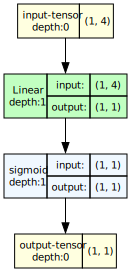

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        out = self.linear(x)
        return torch.sigmoid(out)

from torchview import draw_graph

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LogisticRegression(input_dim = 4, output_dim = 1).to(device)

batch_size = 1
model_graph = draw_graph(model, input_size=(batch_size, 4), expand_nested=True) # device='meta', 
model_graph.visual_graph

The `nn.Linear` module in PyTorch is used to apply a linear transformation to the incoming data, which is a fundamental operation in neural networks. This module is often referred to as a fully connected layer or dense layer.  

`logistic regression = linear regression + sigmoid activation`

调用前面的IrisDataset

In [2]:
%run iris.py # IrisDataset is defined in this script

In [3]:
dataset = IrisDataset()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, drop_last=False)

In [9]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(5):
    for i, (x, y) in enumerate(dataloader):

        x = x.float().to(device)
        y = torch.tensor([int(yi>=1) for yi in y]).float().view(-1,1).to(device)
        
        # Forward pass
        y_pred = model(x) 

        acc = torch.sum(y_pred.round() == y)/len(y)
        print('Accuracy:', acc.item())
        
        # Compute loss
        loss = criterion(y_pred, y)
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Reset gradients
        optimizer.zero_grad() 

Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
